In [16]:
import copy
import networkx as nx
import heapq
import math
from scipy.spatial.distance import euclidean, cityblock
from IPPlanerBase import PlanerBase
import numpy as np
from IPEnvironment import CollisionChecker as cc 



In [17]:
class AStar(PlanerBase):
    def __init__(self, collChecker=0):
        """Contructor:

        Initialize all necessary members"""

        super(AStar, self).__init__(collChecker)
        self.graph = nx.DiGraph()  # = CloseList
        self.openList = []  # (<value>, <node>)

        self.goal = []
        self.goalFound = False

        self.limits = self._collisionChecker.getEnvironmentLimits()

        self.w = 0.5
        return

    def _getNodeID(self, pos):
        """Compute a unique identifier based on the position"""

        nodeId = "-"
        for i in pos:
            nodeId += str(i)+"-"
        return nodeId

    def planPath(self, startList, goalList, config):
        """ 

        Args:
            start (array): start position in planning space
            goal (array) : goal position in planning space
            config (dict): dictionary with the needed information about the configuration options

        Example:

            config["w"] = 0.5
            config["heuristic"] = "euclid"

        """
        # 0. reset
        self.graph.clear()

        # 1. check start and goal whether collision free (s. BaseClass)
        checkedStartList, checkedGoalList = self._checkStartGoal(
            startList, goalList)

        # 2.
        self.w = config["w"]
        self.heuristic = config["heuristic"]
        self.dis = config['dis']
        self.goal = checkedGoalList[0]
        self.lineCollision = config['lineCollision']

        self.solutionPath = []
        self.originalPoints = []
        self.points = []
        self.changedStart = False
        self.changedGoal = False

        if len(self.dis) == 1:
            self.dis = [self.dis[0], self.dis[0]]

        self.originalPoints.append(checkedStartList)
        self.originalPoints.append(checkedGoalList)

        self._newValidPoints(checkedStartList, checkedGoalList)

        if self.changedStart:
            self._addGraphNode(checkedStartList[0])
            currentBestName = self._getBestNodeName()
            currentBest = self.graph.nodes[currentBestName]
            currentBest['collision'] = 0
            currentBest['status'] = 'open'
            self._addGraphNode(self.points[0][0], currentBestName)

        checkedStartList, checkedGoalList = self._checkStartGoal(
            self.points[0], self.points[1])

        self._addGraphNode(checkedStartList[0])
        self.goal = checkedGoalList[0]

        print('start: ', checkedStartList)
        print('goal: ', checkedGoalList)

        breakNumber = 0
        lastCurrentBest = 0
        currentBestName = self._getBestNodeName()
        currentBest = self.graph.nodes[currentBestName]
        while currentBestName:
            if breakNumber > 10000/(self.dis[0]):  # deskratesierung paramter
                break

            breakNumber += 1
            currentBest = self.graph.nodes[currentBestName]

            # print(currentBestName)

            if currentBest["pos"] == self.goal:
                if self.changedGoal:
                    currentBest['collision'] = 0
                    currentBest['status'] = 'open'
                    self._addGraphNode(
                        self.originalPoints[1][0], currentBestName)
                    lastCurrentBest = currentBestName
                    currentBestName = self._getNodeID(
                        self.originalPoints[1][0])
                    currentBest = self.graph.nodes[currentBestName]
                    currentBest['collision'] = 0
                    currentBest['status'] = 'open'

                self._collectPath(currentBestName, self.solutionPath)
                self.goalFound = True
                break

            currentBest["status"] = 'closed'
            if self._collisionChecker.pointInCollision(currentBest["pos"]):
                print('point in collision: ', currentBest["pos"])
                currentBest['collision'] = 1
                currentBestName = self._getBestNodeName()
                continue

            if lastCurrentBest != 0:
                if self._collisionChecker.lineInCollision(lastCurrentBest["pos"], currentBest["pos"]):
                    print('line in colesion : ',
                          lastCurrentBest["pos"], '  ', currentBest["pos"])
                    currentBest['collision'] = 1
                    currentBestName = self._getBestNodeName()
                    continue

            self.graph.nodes[currentBestName]['collision'] = 0

            if self.lineCollision:
                lastCurrentBest = currentBest

            # handleNode merges with former expandNode
            self._handleNode(currentBestName, self.dis)
            currentBestName = self._getBestNodeName()

        if self.goalFound:
            return self.solutionPath
        else:
            return None

    def _insertNodeNameInOpenList(self, nodeName):
        """Get an existing node stored in graph and put it in the OpenList"""
        heapq.heappush(self.openList, (self._evaluateNode(nodeName), nodeName))

    def _addGraphNode(self, pos, fatherName=None):
        """Add a node based on the position into the graph. Attention: Existing node is overwritten!"""
        self.graph.add_node(self._getNodeID(pos), pos=pos, status='open', g=0)

        if fatherName != None:
            self.graph.add_edge(self._getNodeID(pos), fatherName)
            self.graph.nodes[self._getNodeID(
                pos)]["g"] = self.graph.nodes[fatherName]["g"] + 1

        self._insertNodeNameInOpenList(self._getNodeID(pos))

    def _setLimits(self, lowLimit, highLimit):
        """ Sets the limits of the investigated search space """
        assert (len(lowLimit) == len(highLimit) == self.dim)
        self.limits = list()
        for i in range(self.dim):
            self.limits.append([lowLimit[i], highLimit[i]])
        return

    def _getBestNodeName(self):
        """ Returns the best name of best node """
        return heapq.heappop(self.openList)[1]

    def _handleNode(self, nodeName, dis):
        """Generats possible successor positions in all dimensions"""
        result = []
        node = self.graph.nodes[nodeName]
        for i in range(len(node["pos"])):
            for u in [- dis[i], dis[i]]:
                newPos = copy.copy(node["pos"])
                newPos[i] += u
                newPos[i] = round(newPos[i], 9)
                # print( 'new Position: ', newPos[i])
                if not self._inLimits(newPos):
                    continue
                try:
                    self.graph.nodes[self._getNodeID(newPos)]
                    continue
                except:
                    pass

                self._addGraphNode(newPos, nodeName)
                # print(newPos , '  ' , nodeName )

        return result

    def _computeHeuristicValue(self, nodeName):
        """ Computes Heuristic Value: Manhattan Distance """

        result = 0
        node = self.graph.nodes[nodeName]
        if self.heuristic == "euclidean":
            return euclidean(self.goal, node["pos"])
        else:
            return cityblock(self.goal, node["pos"])

    def _evaluateNode(self, nodeName):
        node = self.graph.nodes[nodeName]
        return self.w * self._computeHeuristicValue(nodeName) + (1 - self.w) * node["g"]

    def _collectPath(self, nodeName, solutionPath):

        fathers = list(self.graph.successors(nodeName))
        if len(fathers) == 1:
            self._collectPath(fathers[0], solutionPath)
        elif len(fathers) == 0:
            solutionPath.append(nodeName)
            return
        else:
            raise Exception(
                "not suitable numbers of fathers = {}.... please check".format(len(fathers)))
        solutionPath.append(nodeName)
        return

    def _inLimits(self, pos):
        result = True
        for i, limit in enumerate(self.limits):
            if pos[i] < limit[0] or pos[i] > limit[1]:
                result = False
                break
        return result

    def _getValidNumber(self, number, dis):
        if round(math.fmod(number, dis), 9) != dis:
            if round(math.fmod(number, dis), 9) != 0:
                reminder = round(math.fmod(number, dis), 9)
                x = round((number - reminder), 9)
                y = round((number + round((dis - reminder), 9)), 9)
                if (abs(x-number) > abs(y-number)):
                    return y
                else:
                    return x
            else:
                return number
        else:
            return number

    def _newValidPoints(self, startList, goalList):
        startList = startList[0]
        goalList = goalList[0]

        self.points.append(
            [[self._getValidNumber(startList[0], self.dis[0]), self._getValidNumber(startList[1], self.dis[1])]])
        self.points.append(
            [[self._getValidNumber(goalList[0], self.dis[0]), self._getValidNumber(goalList[1], self.dis[1])]])

        if (startList[0] != self.points[0][0][0]) or (startList[1] != self.points[0][0][1]):
            self.changedStart = True
        if (goalList[0] != self.points[1][0][0]) or (goalList[1] != self.points[1][0][1]):
            self.changedGoal = True

        if self._collisionChecker.lineInCollision(startList, self.points[0][0]):
            raise Exception(
                'Warning: start points are in collision!')
        if self._collisionChecker.lineInCollision(goalList, self.points[1][0]):
            raise Exception(
                'Warning: goal points are in collision!')
        return


In [18]:
def aStarVisualize(planner, solution, ax = None, nodeSize = 300):
    print(solution)
    graph = planner.graph
    collChecker = planner._collisionChecker
    # get a list of positions of all nodes by returning the content of the attribute 'pos'
    pos = nx.get_node_attributes(graph,'pos')
    color = nx.get_node_attributes(graph,'color')
    
    # get a list of degrees of all nodes
    #degree = nx.degree_centrality(graph)
    
    # draw graph (nodes colorized by degree)
    open_nodes = [node for node,attribute in graph.nodes(data=True) if attribute['status']=="open"]
    draw_nodes = nx.draw_networkx_nodes(graph, pos, node_color='#FFFFFF', nodelist=open_nodes, ax = ax, node_size=nodeSize)
    draw_nodes.set_edgecolor("b")
    open_nodes = [node for node,attribute in graph.nodes(data=True) if attribute['status']=="closed"]
    draw_nodes = nx.draw_networkx_nodes(graph, pos, node_color='#0000FF', nodelist=open_nodes, ax = ax, node_size=nodeSize)
    #nx.draw_networkx_nodes(graph, pos,  cmap=plt.cm.Blues, ax = ax, node_size=nodeSize)
    nx.draw_networkx_edges(graph,pos,
                               edge_color='b',
                               width=3.0
                            )
    
    collChecker.drawObstacles(ax)
    
    # draw nodes based on solution path
    Gsp = nx.subgraph(graph,solution)
    nx.draw_networkx_nodes(Gsp,pos,
                            node_size=nodeSize,
                             node_color='g')
        
    # draw edges based on solution path
    nx.draw_networkx_edges(Gsp,pos,alpha=0.8,edge_color='g',width=10,arrows=True)
 
    nx.draw_networkx_nodes(graph,pos,nodelist=[solution[0]],
                           node_size=300,
                           node_color='#00dd00',  ax = ax)
    nx.draw_networkx_labels(graph,pos,labels={solution[0]: "S"},  ax = ax)


    nx.draw_networkx_nodes(graph,pos,nodelist=[solution[-1]],
                                   node_size=300,
                                   node_color='#DD0000',  ax = ax)
    nx.draw_networkx_labels(graph,pos,labels={solution[-1]: "G"},  ax = ax)


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

from shapely.geometry import Point, Polygon, LineString
from IPEnvironment import CollisionChecker

trapField = dict()
trapField["obs1"] =   LineString([(6.5, 18.5), (6.5, 8.5), (16.5, 8.5), (16.5,18.5)]).buffer(0.01)

# Triangles= dict()
# x=1
# y=1.5
# xoffset=2.5
# yoffset=3
# yoffset2=5.5
# xoffsetcircle=5
# #bottom1
# Triangles["obs1"] = LineString([(x, y),           (x+xoffset, y+yoffset), (x+xoffset*2, y)]).buffer(0.07)
# Triangles["obs2"] = LineString([(x+xoffset*2, y), (x+xoffset*3, y+yoffset), (x+xoffset*4, y)]).buffer(0.07)
# Triangles["obs3"] = LineString([(x+xoffset*4, y), (x+xoffset*5, y+yoffset), (x+xoffset*6, y)]).buffer(0.07)
# Triangles["obs4"] = LineString([(x+xoffset*6, y), (x+xoffset*7, y+yoffset), (x+xoffset*8, y)]).buffer(0.07)
# #bottom2
# Triangles["obs5"] = LineString([(x, y+yoffset2),           (x+xoffset, y+yoffset+yoffset2), (x+xoffset*2, y+yoffset2)]).buffer(0.07)
# Triangles["obs6"] = LineString([(x+xoffset*2, y+yoffset2), (x+xoffset*3, y+yoffset+yoffset2), (x+xoffset*4, y+yoffset2)]).buffer(0.07)
# Triangles["obs7"] = LineString([(x+xoffset*4, y+yoffset2), (x+xoffset*5, y+yoffset+yoffset2), (x+xoffset*6, y+yoffset2)]).buffer(0.07)
# Triangles["obs8"] = LineString([(x+xoffset*6, y+yoffset2), (x+xoffset*7, y+yoffset+yoffset2), (x+xoffset*8, y+yoffset2)]).buffer(0.07)

# Triangles["obs9"] = LineString([(x, y+yoffset2*2),           (x+xoffset, y+yoffset+yoffset2*2), (x+xoffset*2, y+yoffset2*2)]).buffer(0.07)
# Triangles["obs10"] = LineString([(x+xoffset*2, y+yoffset2*2), (x+xoffset*3, y+yoffset+yoffset2*2), (x+xoffset*4, y+yoffset2*2)]).buffer(0.07)
# Triangles["obs11"] = LineString([(x+xoffset*4, y+yoffset2*2), (x+xoffset*5, y+yoffset+yoffset2*2), (x+xoffset*6, y+yoffset2*2)]).buffer(0.07)
# Triangles["obs12"] = LineString([(x+xoffset*6, y+yoffset2*2), (x+xoffset*7, y+yoffset+yoffset2*2), (x+xoffset*8, y+yoffset2*2)]).buffer(0.07)

# Triangles["obs13"] = LineString([(x, y+yoffset2*3),           (x+xoffset, y+yoffset+yoffset2*3), (x+xoffset*2, y+yoffset2*3)]).buffer(0.07)
# Triangles["obs14"] = LineString([(x+xoffset*2, y+yoffset2*3), (x+xoffset*3, y+yoffset+yoffset2*3), (x+xoffset*4, y+yoffset2*3)]).buffer(0.07)
# Triangles["obs15"] = LineString([(x+xoffset*4, y+yoffset2*3), (x+xoffset*5, y+yoffset+yoffset2*3), (x+xoffset*6, y+yoffset2*3)]).buffer(0.07)
# Triangles["obs16"] = LineString([(x+xoffset*6, y+yoffset2*3), (x+xoffset*7, y+yoffset+yoffset2*3), (x+xoffset*8, y+yoffset2*3)]).buffer(0.07)

# Triangles["obs17"] = LineString([(x, y+yoffset2*3), (x, y+yoffset2*2)]).buffer(0.07)
# Triangles["obs18"] = LineString([(x, y+yoffset2), (0, y+yoffset2)]).buffer(0.07)
# Triangles["obs19"] = LineString([(x, y+yoffset2), (0, y+yoffset2)]).buffer(0.07)
# Triangles["obs20"] = LineString([(x+xoffset*8, y+yoffset2*0), (x+xoffset*8, y+yoffset2*1)]).buffer(0.07)
# Triangles["obs21"] = LineString([(x+xoffset*8, y+yoffset2*2), (25, y+yoffset2*2)]).buffer(0.07)
# description = "Planer has to find a way through all the triangle."

environment = CollisionChecker(trapField)


start = [[10,14]]
goal  = [[3,14]]
# AStar
astar = AStar(environment)

# To know what is part on the config please consult the documentation of planPath
astarConfig = dict()
astarConfig["w"] = 0.1
astarConfig["heuristic"]  = "euclidean"
astarConfig["dis"]  = [3]
astarConfig["lineCollision"]  = False

solution = astar.planPath( start,goal, astarConfig)
# try:
#     solution = astar.planPath(start, goal, astarConfig)
# except:
#     print('Warning: exeption! ....')
#     solution = astar.planPath(goal, start, astarConfig)


print(solution)

start:  [[9.0, 15.0]]
goal:  [[3, 15.0]]
['-10-14-', '-9.0-15.0-', '-6.0-15.0-', '-3.0-15.0-', '-3-14-']


['-10-14-', '-9.0-15.0-', '-9.0-12.0-', '-9.0-9.0-', '-6.0-9.0-', '-3.0-9.0-', '-3.0-12.0-', '-3.0-15.0-', '-3-14-']


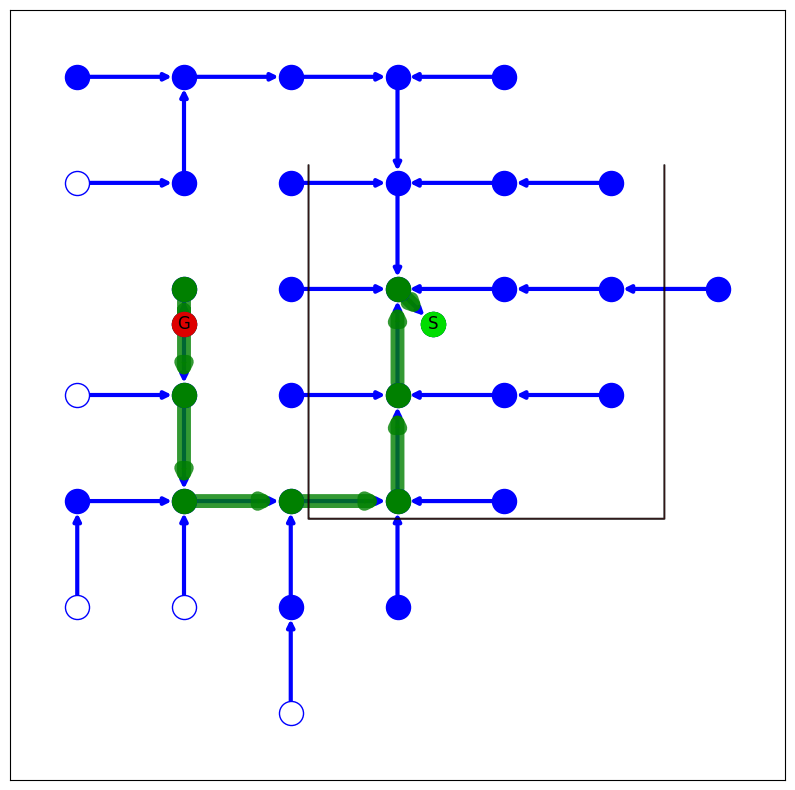

In [27]:
# solution =['-7.0-21.0-', '-17.5-17.5-', '-14.0-10.5-', '-17.5-14.0-', '-14.0-10.5-', '-3.5-21.0-', '-14.0-10.5-', '-17.5-21.0-']
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1)

aStarVisualize(astar, solution, ax = ax)

Name of the Benchmark Trap
start:  [[8.0, 16.0]]
goal:  [[8.0, 0.0]]
line in colesion :  [12.0, 16.0]    [4.0, 16.0]
point in collision:  [8.0, 8.0]
line in colesion :  [12.0, 12.0]    [4.0, 12.0]
point in collision:  [16.0, 16.0]
point in collision:  [12.0, 8.0]
point in collision:  [16.0, 12.0]
line in colesion :  [16.0, 20.0]    [0.0, 16.0]
point in collision:  [16.0, 8.0]
Lösung gefunden
['-10-15-', '-8.0-16.0-', '-12.0-16.0-', '-12.0-20.0-', '-16.0-20.0-', '-20.0-20.0-', '-20.0-16.0-', '-20.0-12.0-', '-20.0-8.0-', '-20.0-4.0-', '-16.0-4.0-', '-12.0-4.0-', '-12.0-0.0-', '-8.0-0.0-', '-10-1-']



Name of the Benchmark Bottleneck
start:  [[4, 16.0]]
goal:  [[16.0, 0.0]]
line in colesion :  [4, 16.0]    [4, 12.0]
line in colesion :  [4, 20.0]    [8, 12.0]
line in colesion :  [12, 16.0]    [0, 12.0]
line in colesion :  [8, 20.0]    [12, 12.0]
line in colesion :  [12, 20.0]    [16, 12.0]
line in colesion :  [16, 20.0]    [20, 12.0]
start:  [[16.0, 0.0]]
goal:  [[4, 16.0]]
line in colesi

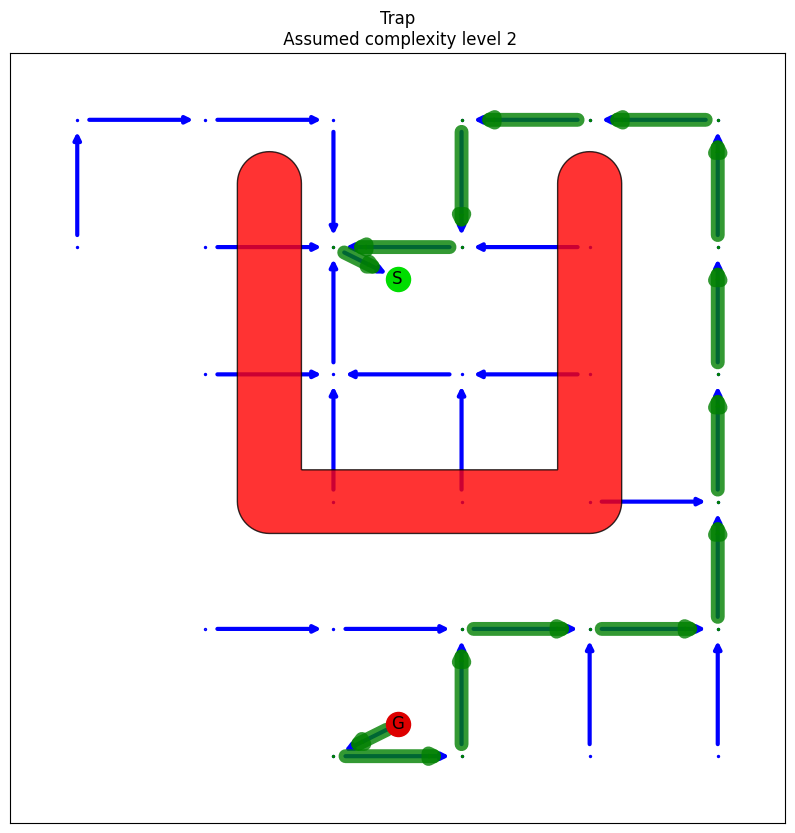

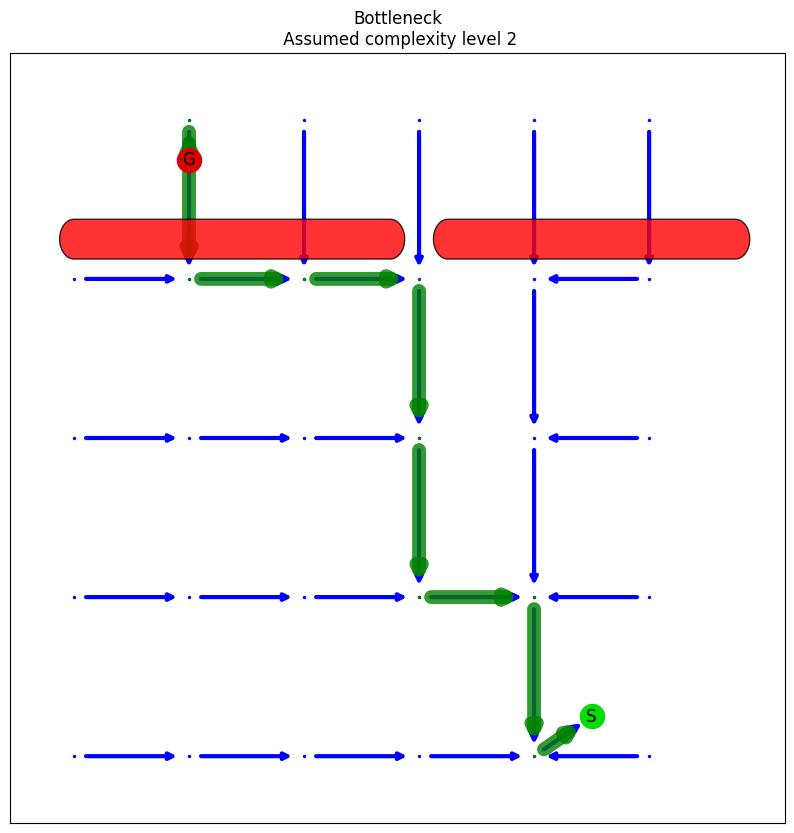

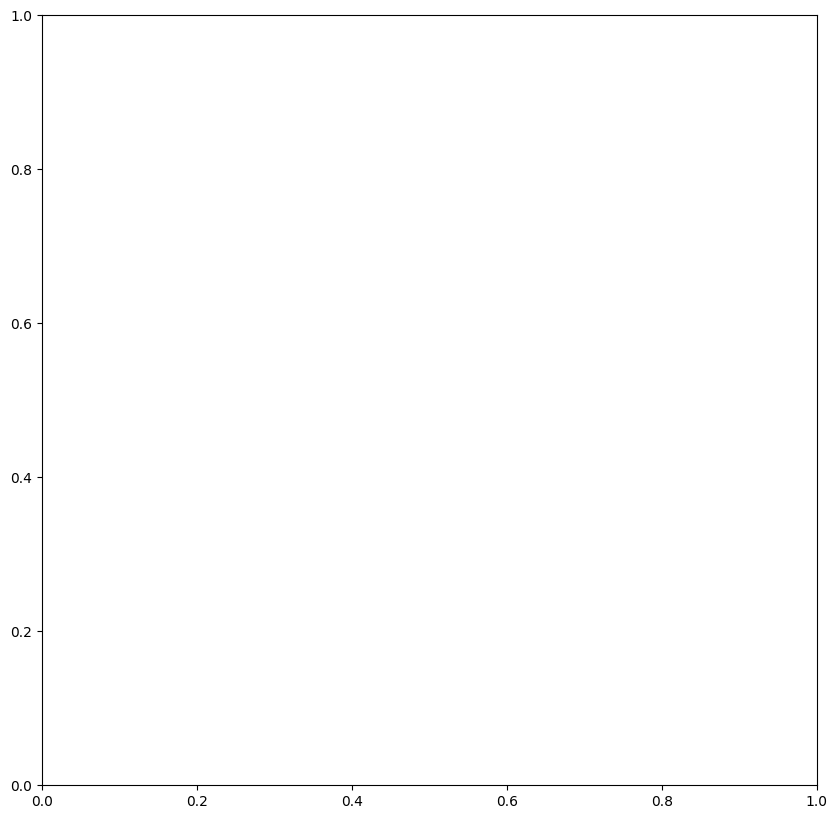

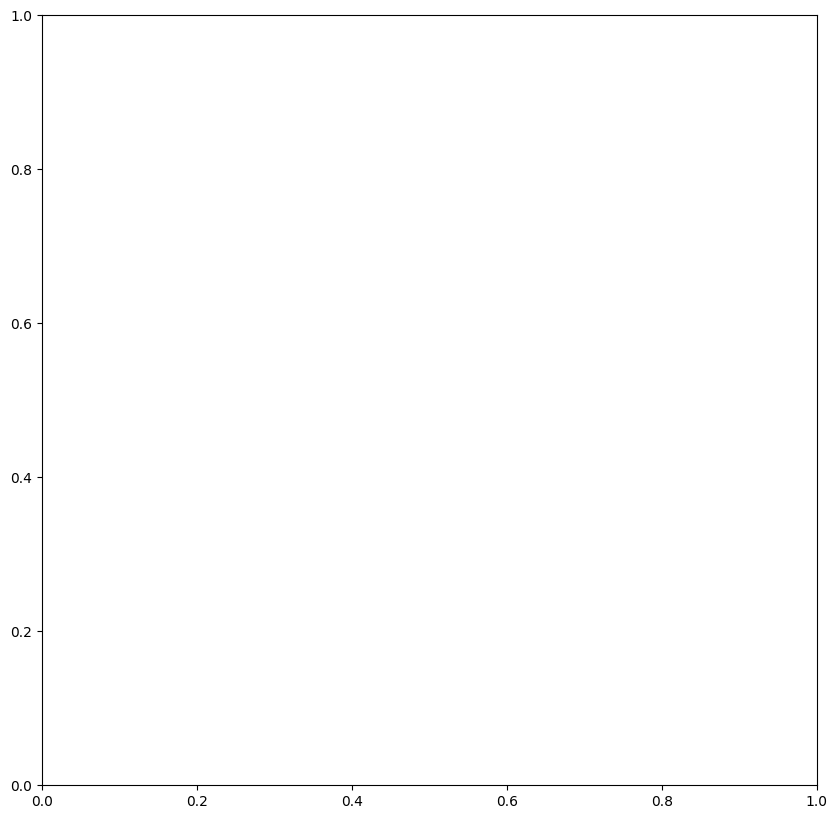

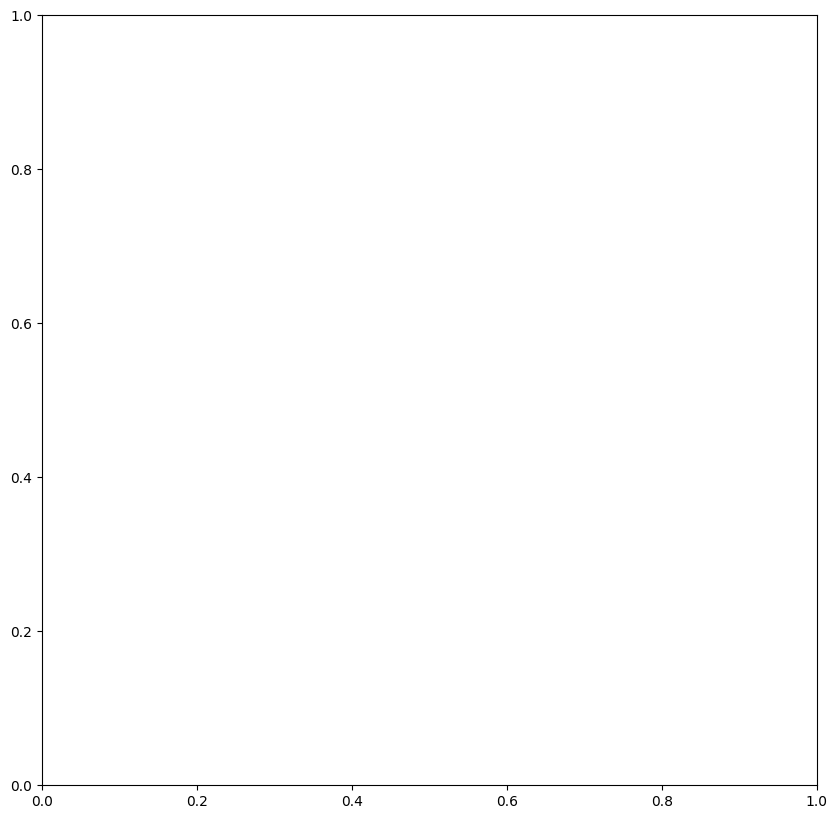

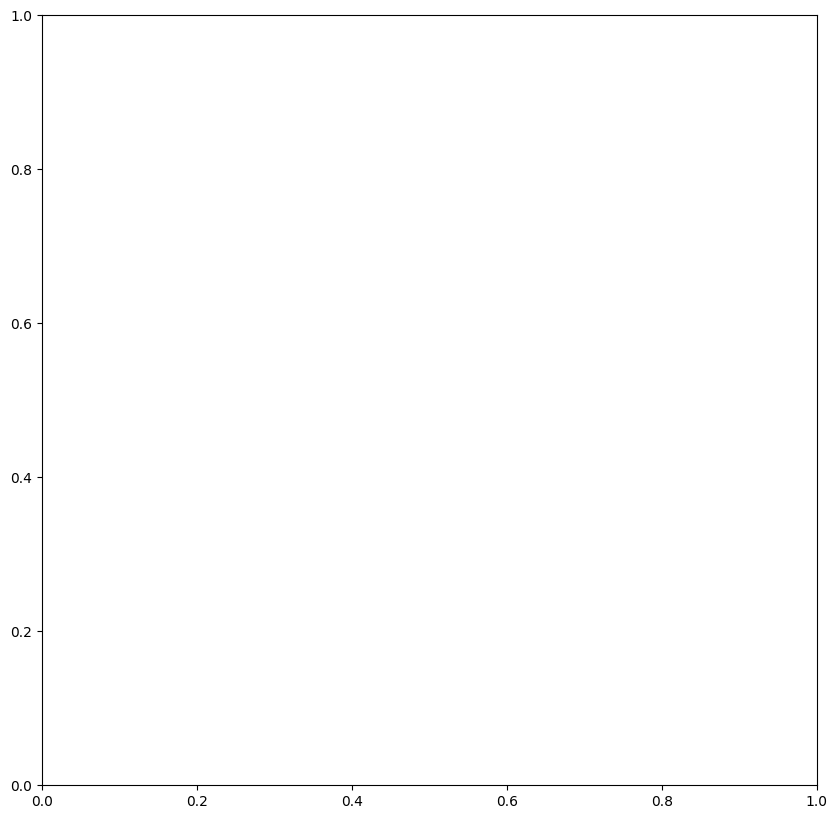

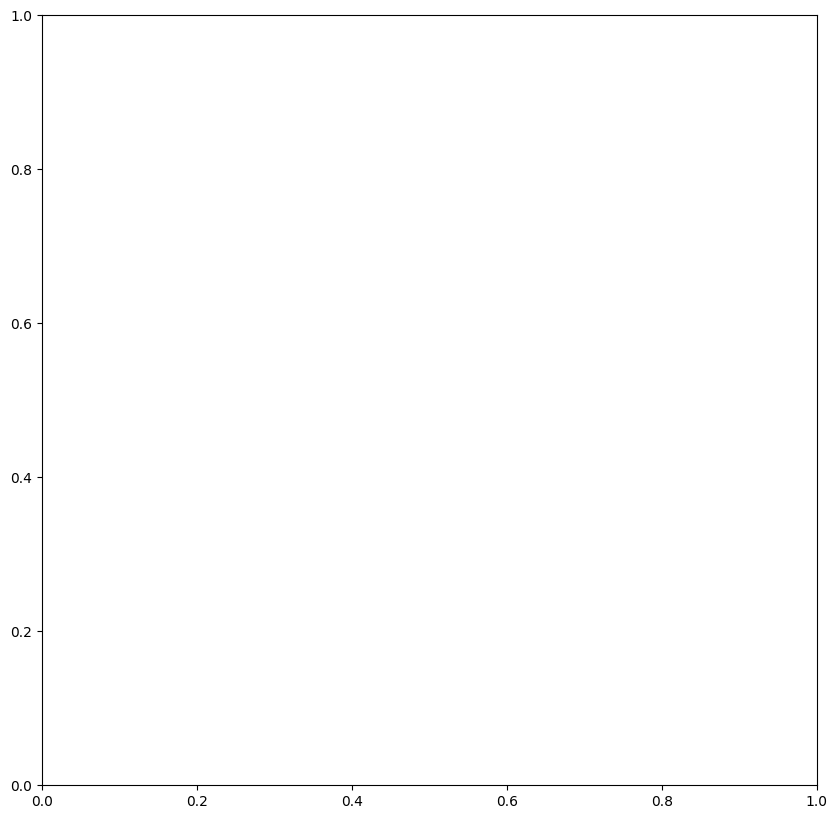

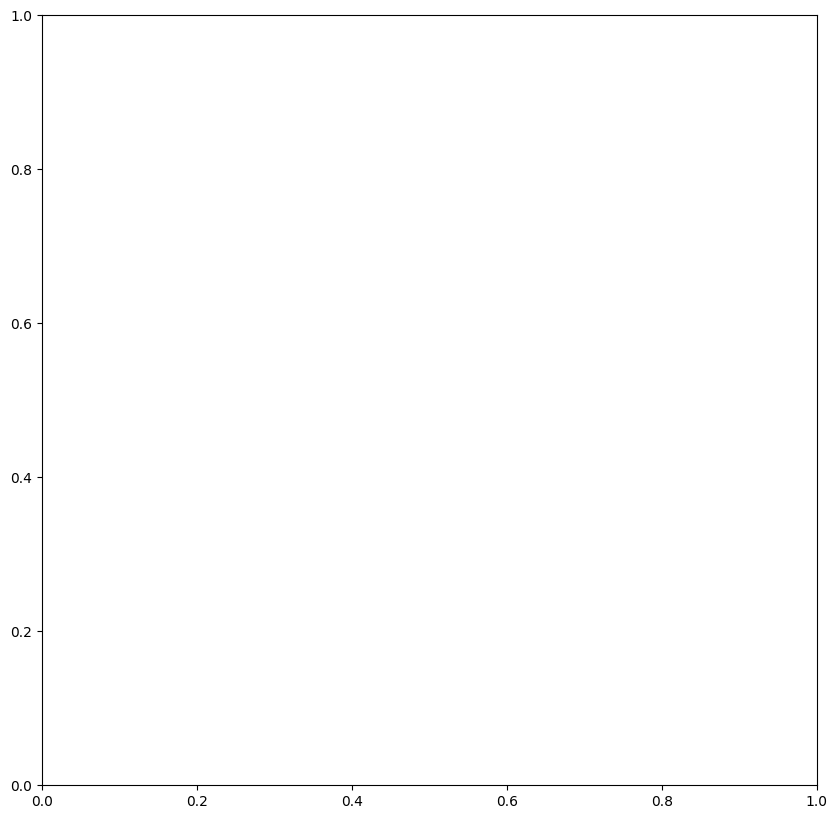

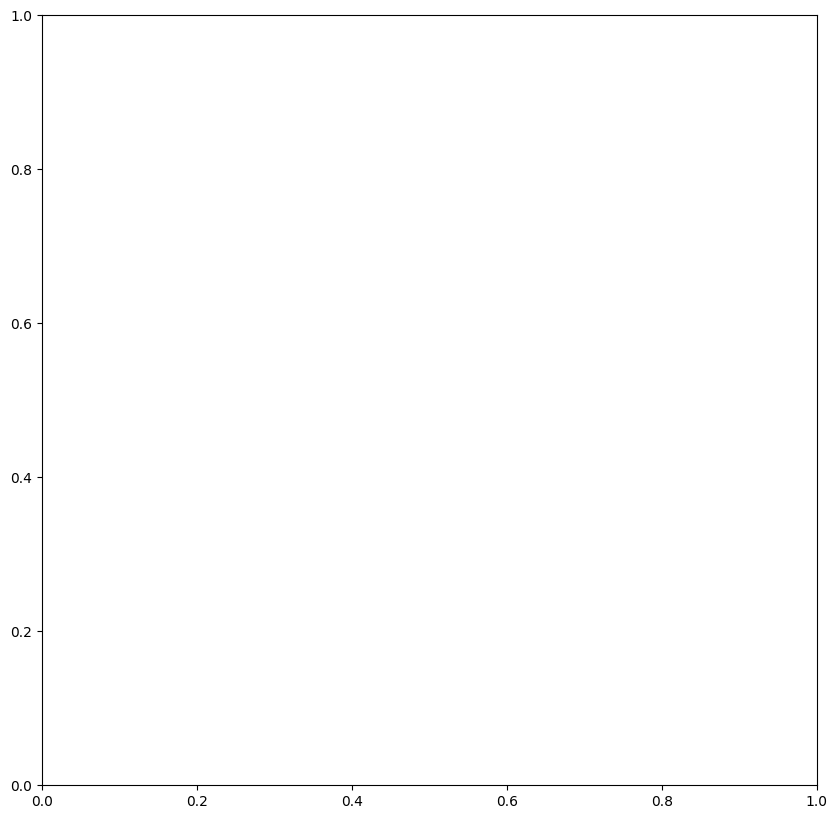

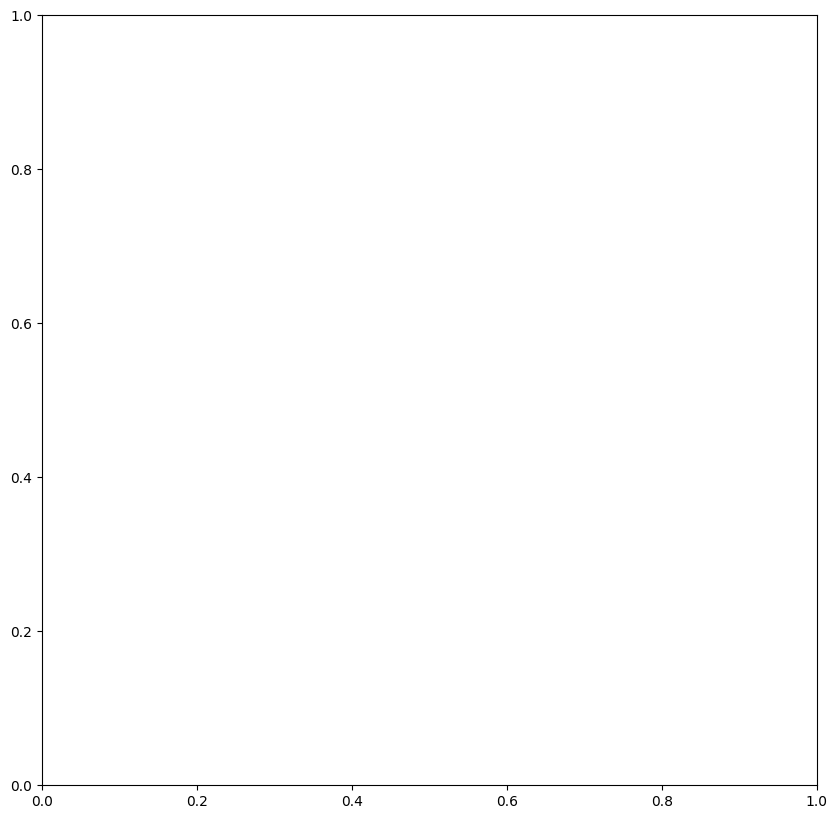

In [21]:

import IPTestSuiteWS2223
benchList = IPTestSuiteWS2223.benchList

astarConfig = dict()
astarConfig["w"] = 0.1
astarConfig["heuristic"] = "euclidean"
astarConfig["dis"] = [4]
astarConfig["lineCollision"] = True

testlist = benchList[0:10]
for bench in testlist:
    print("Name of the Benchmark", bench.name)
    try:
        fig_local = plt.figure(figsize=(10, 10))
        ax = fig_local.add_subplot(1, 1, 1)
        astarPRM = AStar(bench.collisionChecker)
        try:
            solution = astarPRM.planPath(
                bench.startList, bench.goalList, astarConfig)
        except:
            print('Warning: exeption! ....')
            solution = astarPRM.planPath(
                bench.goalList, bench.startList, astarConfig)
        if solution != []:
            print("Lösung gefunden")
        elif solution == []:
            print("noch keinen Lösungsweg gefunden")

        title = bench.name
        if solution == []:
            title += " (No path found!)"
        title += "\n Assumed complexity level " + str(bench.level)
        ax.set_title(title)
        aStarVisualize(astarPRM, solution, ax=ax, nodeSize=2)

    except Exception as e:
        print("keine lösung gefunden", bench.name, e)

    print("\n\n")
